# Logistic Regression
https://realpython.com/logistic-regression-python/

Logistic regression model is based on a sigmoid function that has values very close to either 0 or 1 across most of its domain.
$$\sigma(x) = \frac{1}{1+exp(-x)}$$
The interpretation is that the probability that the output for a given 𝐱 is equal to 1 is
$$p(x) = \sigma(f(x)),$$
where $f(x)$ is a linear function logit
$$f(x) = b_{0}+b_{1}x_{1}+...+b_{r}x_{r}$$
and $b_{i}$ are the estimators of the regression coefficients, which are also called the predicted weights or just coefficients. For each observation 𝑖 = 1, …, 𝑛, the predicted output is 1 if 𝑝(𝐱ᵢ) > 0.5 and 0 otherwise. The threshold doesn’t have to be 0.5, but it usually is.
$$ln(\frac{p(𝐱)}{1-p(𝐱)})=f(𝐱)$$
It implies that 𝑝(𝐱) = 0.5 when 𝑓(𝐱) = 0 and that the predicted output is 1 if 𝑓(𝐱) > 0 and 0 otherwise.

In [1]:
import os
os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import  accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 600)

#### Import `df`

In [2]:
df = pd.read_csv('data/df.csv')
df.head()

,is_churn,city_0,city_1,city_3,city_4,city_5,city_6,city_7,city_8,city_9,...,discount1_-894.0,discount1_-799.0,discount1_-150.0,discount1_-149.0,discount1_-129.0,discount1_-50.0,discount1_0.0,discount1_20.0,discount1_30.0,discount1_149.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### Explanatory and response variables

In [3]:
X = df.drop('is_churn', axis=1) # drop unknown churn
y = df[['is_churn']]
y = np.ravel(y)
y[:5]

array([0, 1, 0, 1, 0], dtype=int64)

#### Quality Metrics

In [74]:
def confusion_matrix_plot(y_actual, y_predicted):
    '''Plot Binary Confusion Matrix for actual and predicted labels'''
    #from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_actual, y_predicted)
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    print("[[TN, FP], [FN, TP]] =\n",cm) # print confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red') # counts
    plt.show();
    return tn,fp,fn,tp

def metrics(X, y_actual, model, tn,fp,fn,tp):
    '''Quality Metrics'''
    tnr = tn/(tn + fp) # tnr = 1-fpr
    print(f"TNR = {round(tnr,4)} Specificity, proportion of the negative class 0 got correctly classified.")
    fpr = fp/(tn + fp)
    fnr = fn/(tp + fn)
    print(f"FNR = {round(fnr,4)} or Type II Error: Proportion of the positive class 1 got incorrectly classified.")
    tpr = tp/(tp + fn)
    y_score = model.predict_proba(X)[:,1] # probabilities of prediction=0,1
    roc_auc = roc_auc_score(y_actual, y_score)
    print(f"roc_auc_score = {round(roc_auc,4)}")
    y_predicted = model.predict(X)
    accuracy = accuracy_score(y_actual, y_predicted)
    print(f"Accuracy = {round(accuracy,4)}: (TN+TP)/(TN+TP+FN+FP): Percentage of total items classified correctly")
    # accuracy_nosplit = log_reg_nosplit.score(X, y)
    print(f"FPR = {round(fpr,4)} Specificity, or Type I Error: proportion of the negative class 0 got incorrectly classified.")  
    print(f"TPR = {round(tpr,4)}: TP/(TP+FN): Recall, sensitivity, proportion of the positive class 1 got correctly classified.")
    #print('Recall =', recall_score(y_actual, y_predicted))
    print(f"Precision = {round(precision_score(y_actual, y_predicted),4)}: TP/PP = TP/(TP+FP)")
    print(f"F1 score = {round(f1_score(y_actual, y_predicted),4)}: harmonic mean of precision and recall.")
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"MCC = {round(MCC,4)} Matthews correlation coefficient: accounts for all 4 confusion matrix categories.")

#### Training without splitting

In [75]:
# Create and train the Logistic Regression model
lr_nosplit = LogisticRegression(random_state=0, solver='lbfgs').fit(X,y)
#solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}

[[TN, FP], [FN, TP]] =
 [[1565   29]
 [ 115  203]]


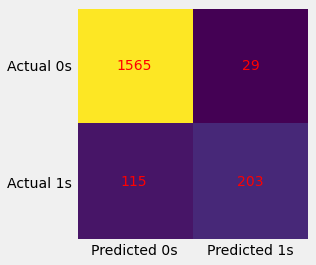

TNR = 0.9818 Specificity, proportion of the negative class 0 got correctly classified.
FNR = 0.3616 or Type II Error: Proportion of the positive class 1 got incorrectly classified.
roc_auc_score = 0.957
Accuracy = 0.9247: (TN+TP)/(TN+TP+FN+FP): Percentage of total items classified correctly
FPR = 0.0182 Specificity, or Type I Error: proportion of the negative class 0 got incorrectly classified.
TPR = 0.6384: TP/(TP+FN): Recall, sensitivity, proportion of the positive class 1 got correctly classified.
Precision = 0.875: TP/PP = TP/(TP+FP)
F1 score = 0.7382: harmonic mean of precision and recall.
MCC = 0.7072 Matthews correlation coefficient: accounts for all 4 confusion matrix categories.
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1594
           1       0.88      0.64      0.74       318

    accuracy                           0.92      1912
   macro avg       0.90      0.81      0.85      1912
weighted avg       0.92      0.

In [76]:
y_predicted = lr_nosplit.predict(X) # Predicted labels
# Evaluate the Model
tn,fp,fn,tp = confusion_matrix_plot(y, y_predicted)
metrics(X, y, lr_nosplit, tn,fp,fn,tp)
accuracy_nosplit = accuracy_score(y, y_predicted)
print(classification_report(y, y_predicted))

In [77]:
print("Distinct values that y takes:",lr_nosplit.classes_)
# probability of y=0 (1st column) and y=1 (2nd column)
print("Prediction Probabilities (top):\n", lr_nosplit.predict_proba(X)[:3])
print("Regression Coefficients:\n")
b0_nosplit = lr_nosplit.intercept_[0]
print("Intercept b0 =", b0_nosplit)
b_nosplit = lr_nosplit.coef_
print("Coefficients b =", b_nosplit)

Distinct values that y takes: [0 1]
Prediction Probabilities (top):
 [[0.90980211 0.09019789]
 [0.02648739 0.97351261]
 [0.99816207 0.00183793]]
Regression Coefficients:

Intercept b0 = 0.36667415078342114
Coefficients b = [[ 2.15377001e-01 -1.11674448e-01 -8.57438214e-02 -8.42375271e-02
   4.64769065e-01  5.59051481e-02 -4.27450553e-01  1.55579041e-01
   2.75652053e-01 -6.50513218e-03 -1.43363528e-01  1.35475691e-01
  -1.87607600e-01  1.12207726e-01  4.26498727e-01  7.60932714e-02
  -1.26886798e-01  9.66553524e-02  4.72198710e-02 -8.88029389e-01
   4.18984720e-01  8.54246569e-02  3.59332515e-01 -2.86796893e-01
  -2.64524718e-01 -1.25432871e+00  4.28689118e-01 -1.04622963e-01
   2.21990652e-01 -4.37947287e-01 -9.31447935e-01 -2.62668196e-01
   7.07313575e-02  4.53934885e-01 -8.76473768e-01 -1.02887960e+00
  -1.81295154e-02 -4.03776028e-01  2.63410611e-01  2.02765977e-01
  -2.65061330e-01 -7.31297219e-02  3.13572832e-01  4.20004459e-01
  -3.73895062e-01  1.16425321e+00 -5.30218115e-01  

#### 3.2.2 Training with splitting
Taking 70% for training set and 30% for test set.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])

Train samples: 1338
Test samples: 574


In [79]:
# Create and train the Logistic Regression model
#solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
lr_split = LogisticRegression(solver='lbfgs', random_state=0); # Create a model
lr_split.fit(X_train, y_train); # Train model using training set

[[TN, FP], [FN, TP]] =
 [[466  12]
 [ 40  56]]


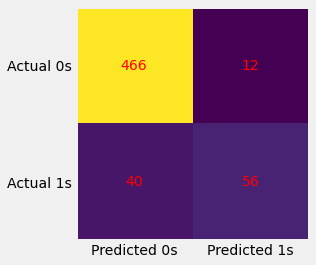

TNR = 0.9749 Specificity, proportion of the negative class 0 got correctly classified.
FNR = 0.4167 or Type II Error: Proportion of the positive class 1 got incorrectly classified.
roc_auc_score = 0.9212
Accuracy = 0.9094: (TN+TP)/(TN+TP+FN+FP): Percentage of total items classified correctly
FPR = 0.0251 Specificity, or Type I Error: proportion of the negative class 0 got incorrectly classified.
TPR = 0.5833: TP/(TP+FN): Recall, sensitivity, proportion of the positive class 1 got correctly classified.
Precision = 0.8235: TP/PP = TP/(TP+FP)
F1 score = 0.6829: harmonic mean of precision and recall.
MCC = 0.6447 Matthews correlation coefficient: accounts for all 4 confusion matrix categories.
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       478
           1       0.82      0.58      0.68        96

    accuracy                           0.91       574
   macro avg       0.87      0.78      0.82       574
weighted avg       0.90      

In [80]:
y_pred_split = lr_split.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred_split)
metrics(X_test, y_test, lr_split, tn,fp,fn,tp)
print(classification_report(y_test, y_pred_split))

In [81]:
print("Distinct values that y takes:",lr_split.classes_)
# probability of y=0 (1st column) and y=1 (2nd column)
print("Prediction Probabilities (top):\n", lr_split.predict_proba(X_test)[:3])
print("Regression Coefficients:\n")
b0_split = lr_split.intercept_[0]
print("Intercept b0 =", b0_split)
b_split = lr_split.coef_
print("Coefficients b =", b_split)

Distinct values that y takes: [0 1]
Prediction Probabilities (top):
 [[0.63094851 0.36905149]
 [0.91142576 0.08857424]
 [0.98144328 0.01855672]]
Regression Coefficients:

Intercept b0 = 0.2662117679027964
Coefficients b = [[ 3.04156850e-01  2.55983127e-02 -9.67334929e-02 -3.65241851e-01
   5.79997908e-01 -1.21932546e-01 -5.37619578e-01 -8.33357219e-02
  -3.70807788e-01 -1.70656582e-01 -1.16929108e-01  1.99377425e-01
   6.53832185e-02  2.40553772e-01  4.59132919e-01  0.00000000e+00
   4.94447192e-01 -2.22831970e-02  1.92204738e-01 -6.75288829e-01
   1.51781543e-02  0.00000000e+00  3.25286492e-01 -1.81030017e-01
  -2.81216987e-01 -1.17888384e+00  5.35885697e-01  1.45810877e-01
   3.21890033e-01 -2.47999727e-01 -9.39009603e-01  1.92032704e-01
  -1.70305081e-01  3.85807624e-01 -5.23711475e-01 -6.34080689e-01
  -2.38392576e-01 -2.00466104e-01 -2.53189154e-01  2.15870049e-01
   3.35491912e-02  7.51470519e-02  4.22668183e-01 -1.11843697e-01
  -4.02739035e-01  5.14267506e-01 -1.73520108e-01  2

#### Comparison to no split
Quality of the model does not depend on the solver in both cases of no split and 30% test set. Compared to no splitting, many of the model coefficients differ by more than 20%,

In [82]:
print("Intercept relative error:",b0_split/b0_nosplit-1)
print("Coefficient relative error:",b_split/b_nosplit-1)

Intercept relative error: -0.27398272462343176
Coefficient relative error: [[ 4.12206725e-01 -1.22922265e+00  1.28168670e-01  3.33585675e+00
   2.47927092e-01 -3.18106114e+00  2.57735132e-01 -1.53564877e+00
  -2.34520234e+00  2.52341451e+01 -1.84387340e-01  4.71684141e-01
  -1.34851050e+00  1.14382540e+00  7.65165039e-02 -1.00000000e+00
  -4.89675836e+00 -1.23054281e+00  3.07042065e+00 -2.39564775e-01
  -9.63773967e-01 -1.00000000e+00 -9.47479609e-02 -3.68786686e-01
   6.31028702e-02 -6.01476057e-02  2.50056684e-01 -2.39367949e+00
   4.50016163e-01 -4.33722427e-01  8.11818658e-03 -1.73108472e+00
  -3.40777339e+00 -1.50081571e-01 -4.02479008e-01 -3.83717310e-01
   1.21494180e+01 -5.03521531e-01 -1.96119573e+00  6.46265807e-02
  -1.12657143e+00 -2.02758564e+00  3.47910725e-01 -1.26629169e+00
   7.71445686e-02 -5.58285516e-01 -6.72738251e-01 -2.41064791e-01
   9.53799817e-01  5.41743478e+00  2.05490461e+00  5.85707200e-02
  -1.04669569e-02 -1.13621811e-01 -1.84308049e-01  1.06632945e-01
 

<ipython-input-82-69d93c4e9c82>:2: RuntimeWarning: invalid value encountered in true_divide
  print("Coefficient relative error:",b_split/b_nosplit-1)


and all quality metrics are considerably worse than for no split (Accuracy is 1.65% lower, FPR is 37.9% higher, TPR is 8.69% lower, Precision is 5.89% lower, F1 score is 7.49% lower, and MCC is 8.84% lower).

In [83]:
roc_auc_nosplit = 0.957
roc_auc_split = 0.9212
print("Relative difference in ROC AUC =", roc_auc_split/roc_auc_nosplit-1)

Relative difference in ROC AUC = -0.03740856844305118


The change in the proportion of positive values 1 of the label `is_churn` in the test dataset compared to the full dataset is only 0.56%,

In [84]:
print("Proportion of `is_churn==1` in the full set:", np.sum(y)/len(y))

Proportion of `is_churn==1` in the full set: 0.16631799163179917


In [85]:
print("Proportion of `is_churn==1` in the test set:", np.sum(y_test)/len(y_test))

Proportion of `is_churn==1` in the test set: 0.1672473867595819


so this is not the reason for the considerable reduction in model quality.

#### 3.2.3 Optimization of the regularization parameter C
Let's try to adjust the regularization strength C.

In [86]:
def opt_C_rocauc(Cmin,Cmax,Cstep):#Cmax+Cstep
    '''Optimize regularization parameter C by maximizing accuracy in Logistic Regression for Train-Test split.'''
    rocauc = pd.DataFrame({'C':[],'ROC AUC':[]})
    rocauc_opt = 0
    for C in np.arange(Cmin, Cmax, Cstep):
        lr_C = LogisticRegression(C=C, random_state=0, max_iter=3000).fit(X_train, y_train)
        pred = lr_C.predict(X_test) # predicted values
        metric = roc_auc_score(y_test, lr_C.predict_proba(X_test)[:, 1]) # ROC AUC score
        rocauc = rocauc.append({'C':C,'ROC AUC':metric}, ignore_index=True)
        if rocauc_opt < metric:
            rocauc_opt = metric
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest ROC AUC =',rocauc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(rocauc['C'],rocauc['ROC AUC']);
    plt.xlabel('C');
    plt.ylabel('ROC AUC');

def opt_C_accuracy(Cmin,Cmax,Cstep):
    '''Optimize regularization parameter C by maximizing accuracy in Logistic Regression for Train-Test split.'''
    accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
    acc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        lr_C = LogisticRegression(C=C, random_state=0, max_iter=3000).fit(X_train, y_train)
        pred = lr_C.predict(X_test) # predicted values
        acc = lr_C.score(X_test, y_test) # proportion of correct predictions
        accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
        if acc_opt < acc:
            acc_opt = acc
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest accuracy =',acc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(accuracy['C'],accuracy['Accuracy']);
    plt.xlabel('C');
    plt.ylabel('Accuracy');

Optimal C = 1.6
Highest accuracy = 0.9279441248256625


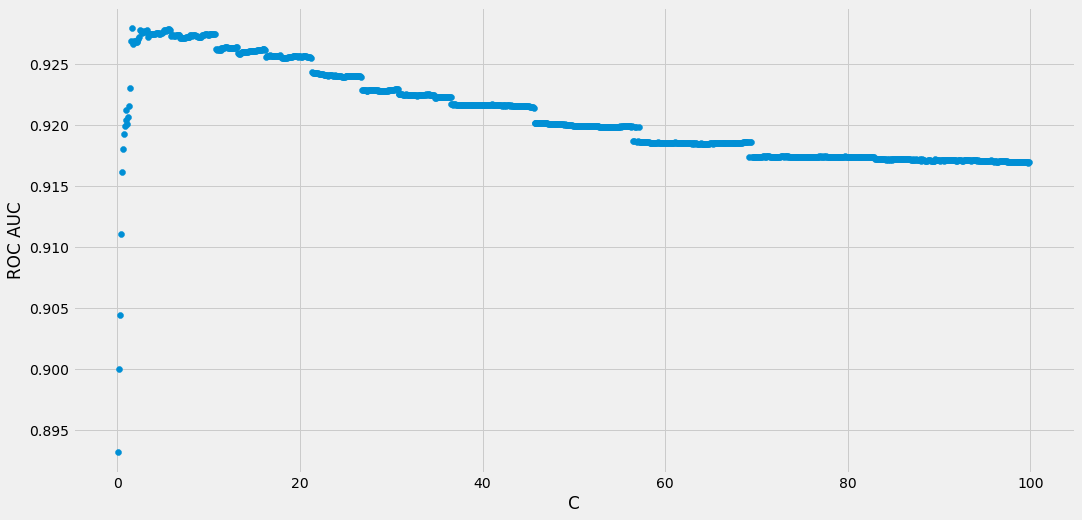

In [38]:
opt_C_rocauc(0.1,100,0.1)

Optimal C = 1.55
Highest ROC AUC = 0.9280530857740587


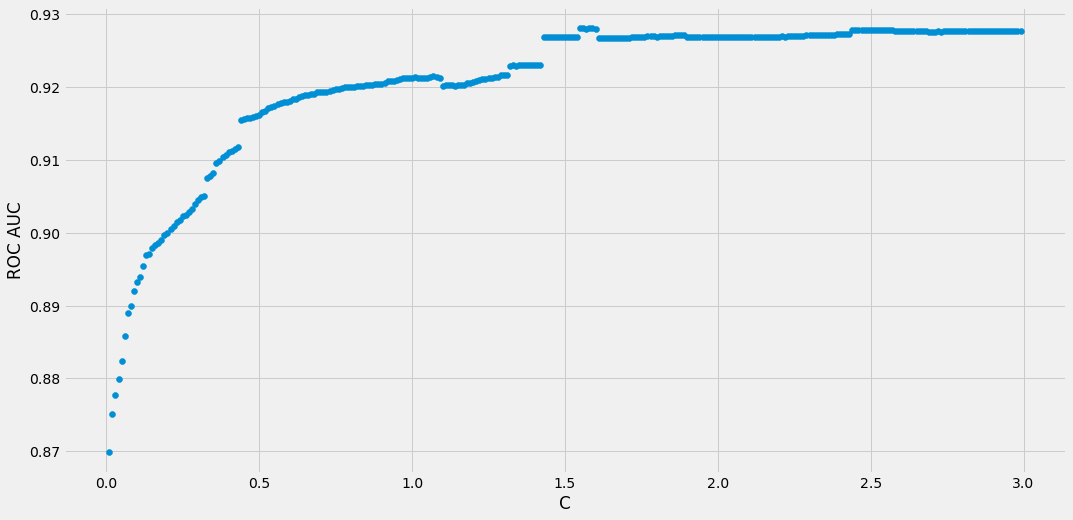

In [56]:
opt_C_rocauc(0.01,3,0.01)

Optimal C = 0.4
Highest accuracy = 0.9094076655052264


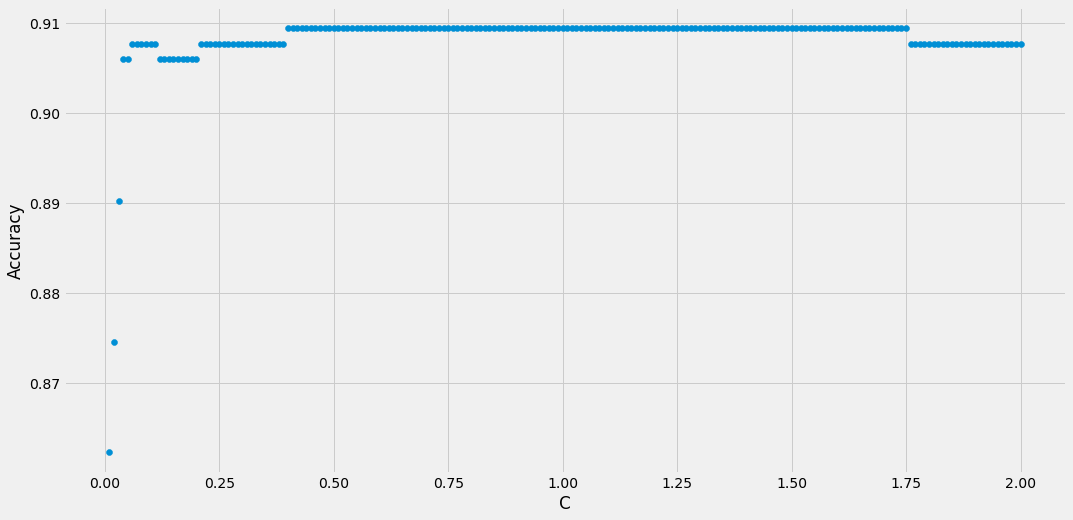

In [39]:
opt_C_accuracy(0.01,2,0.01)
#Optimal C = 0.4
#Highest accuracy = 0.9094076655052264

Optimized C in Logistic Regression with 30% test split:
[[TN, FP], [FN, TP]] =
 [[466  12]
 [ 40  56]]


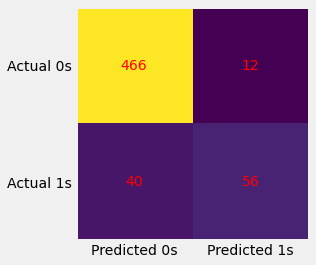

TNR = 0.9749 Specificity, proportion of the negative class 0 got correctly classified.
FNR = 0.4167 or Type II Error: Proportion of the positive class 1 got incorrectly classified.
roc_auc_score = 0.9281
Accuracy = 0.9094: (TN+TP)/(TN+TP+FN+FP): Percentage of total items classified correctly
FPR = 0.0251 Specificity, or Type I Error: proportion of the negative class 0 got incorrectly classified.
TPR = 0.5833: TP/(TP+FN): Recall, sensitivity, proportion of the positive class 1 got correctly classified.
Precision = 0.8235: TP/PP = TP/(TP+FP)
F1 score = 0.6829: harmonic mean of precision and recall.
MCC = 0.6447 Matthews correlation coefficient: accounts for all 4 confusion matrix categories.
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1594
           1       0.88      0.64      0.74       318

    accuracy                           0.92      1912
   macro avg       0.90      0.81      0.85      1912
weighted avg       0.92      

In [88]:
print('Optimized C in Logistic Regression with 30% test split:')
C_opt = 1.55
lr_C = LogisticRegression(C=C_opt, random_state=0, max_iter=3000).fit(X_train, y_train) # Create and train model using training set
pred_C = lr_C.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, pred_C)
metrics(X_test, y_test, lr_C, tn,fp,fn,tp)
print(classification_report(y, y_predicted))

Optimization of the regularization parameter 'C' did not lead to an improvement in accuracy, since the accuracy and other performance metrics stay same for $C \in [0.392, 1.756]$. A way to increase recall is to adjust the threshold probability, which will be done below when considering ROC and Precision-Recall curves.

#### Cross-Validation
A more reliable way of validating the model and optimizing its parameters is by cross-validation.

In [136]:
from sklearn.model_selection import cross_val_score
print("Example of cross-validation:")
lr_cv = LogisticRegression(random_state=0) #solver='liblinear'
scores = cross_val_score(lr_cv, X, y, cv=10) #X_train, y_train
print('Cross-Validation Accuracy Scores', scores)
scores.min(), scores.mean(), scores.max()

Example of cross-validation:
Cross-Validation Accuracy Scores [0.96354167 0.921875   0.91099476 0.91623037 0.89005236 0.88481675
 0.93193717 0.87434555 0.90052356 0.91623037]


(0.8743455497382199, 0.9110547556719023, 0.9635416666666666)

In [153]:
def optCV_C_rocauc(Cmin,Cmax,Cstep, solver='lbfgs'):
    '''Optimize regularization parameter C by maximizing accuracy in Logistic Regression with 10-fold Cross-Validation.'''
    rocauc = pd.DataFrame({'C':[],'ROC AUC':[]})
    rocauc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        lr_cv = LogisticRegression(C=C, solver=solver, random_state=0, max_iter=3000).fit(X_train, y_train)
        metric = np.mean(cross_val_score(lr_cv, X, y, scoring='roc_auc', cv=10)) # accuracies of cv cross-validations
        rocauc = rocauc.append({'C':C,'ROC AUC':metric}, ignore_index=True)
        if rocauc_opt < metric:
            rocauc_opt = metric
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest ROC AUC =',rocauc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(rocauc['C'],rocauc['ROC AUC']);
    plt.xlabel('C');
    plt.ylabel('ROC AUC');
    #display(rocauc)

def optCV_C_accuracy(Cmin,Cmax,Cstep, solver='lbfgs'):
    '''Optimize regularization parameter C in Logistic Regression with 10-fold Cross-Validation'''
    accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
    acc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        log_reg_cv = LogisticRegression(C=C, solver=solver, max_iter=3000, random_state=0) #liblinear
        scores = cross_val_score(log_reg_cv, X, y, cv=10) # accuracies of cv cross-validations
        acc = scores.mean()
        accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
        if acc_opt < acc:
            acc_opt = acc
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest accuracy =',acc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(accuracy['C'],accuracy['Accuracy']);
    plt.xlabel('C');
    plt.ylabel('Accuracy');
    #display(accuracy)

Optimal C = 3
Highest ROC AUC = 0.916164968331558


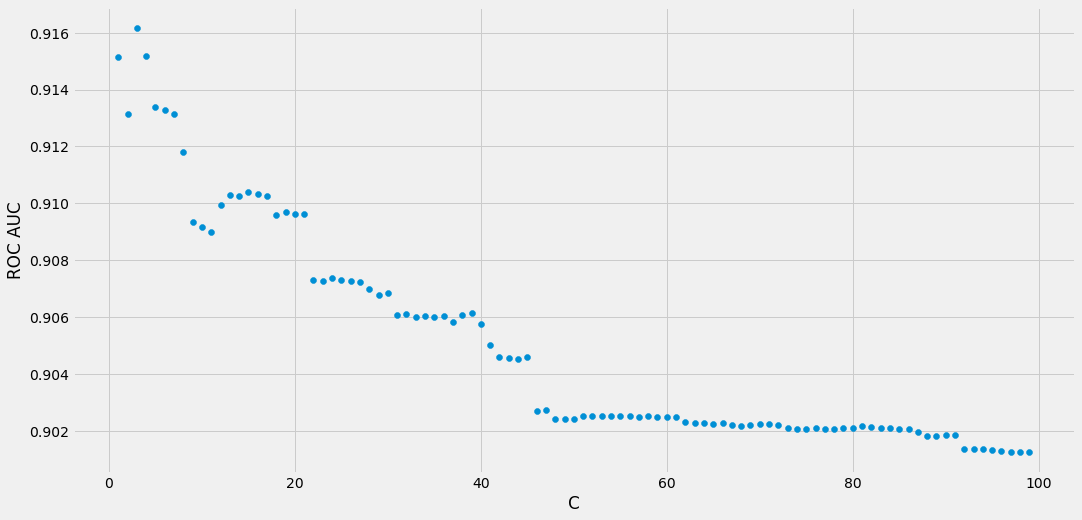

In [126]:
optCV_C_rocauc(1, 100, 1)

Optimal C = 2.8000000000000003
Highest ROC AUC = 0.9168929383178636


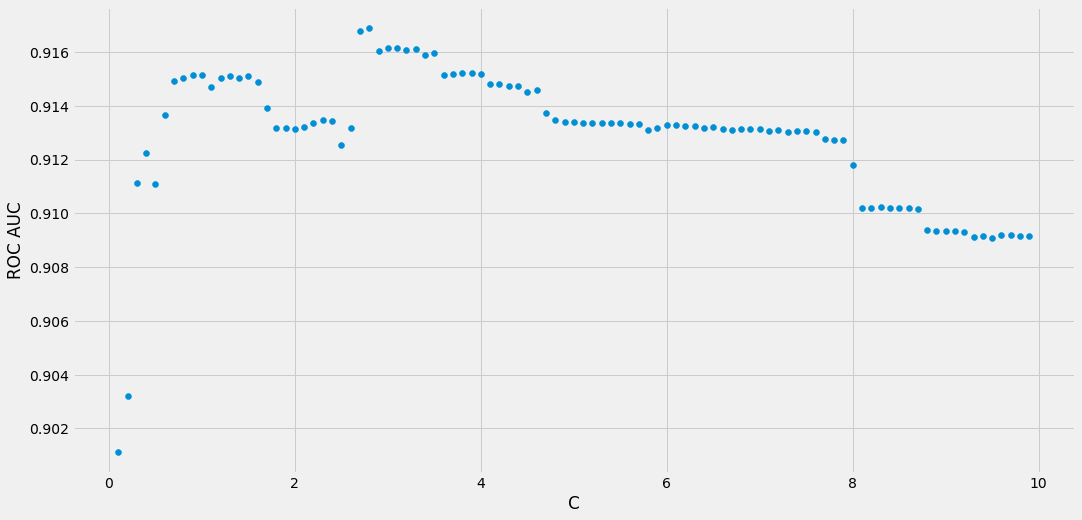

In [125]:
optCV_C_rocauc(0.1, 10, 0.1)

Optimal C = 2.760000000000002
Highest ROC AUC = 0.9169123467298131


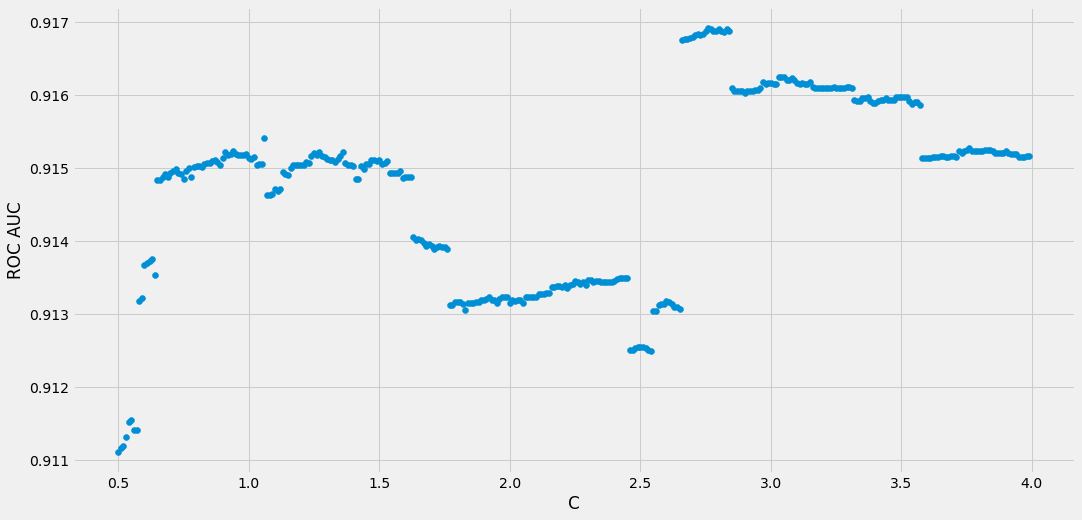

In [129]:
optCV_C_rocauc(0.5, 4, 0.01)

Optimal C = 0.2
Highest accuracy = 0.9162767233856893


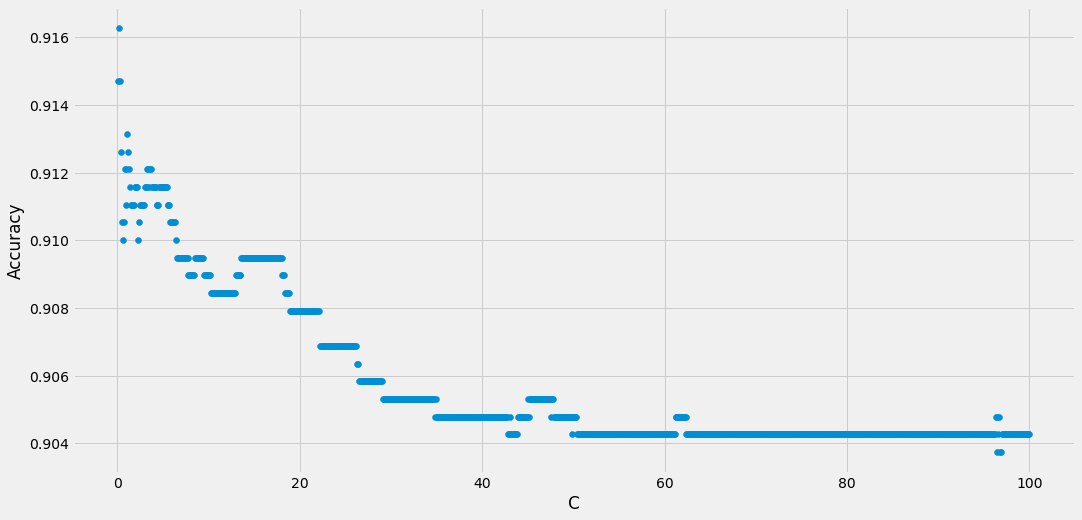

In [93]:
optCV_C_accuracy(0.1, 100, 0.1)

Optimal C = 0.22
Highest accuracy = 0.9162794502617801


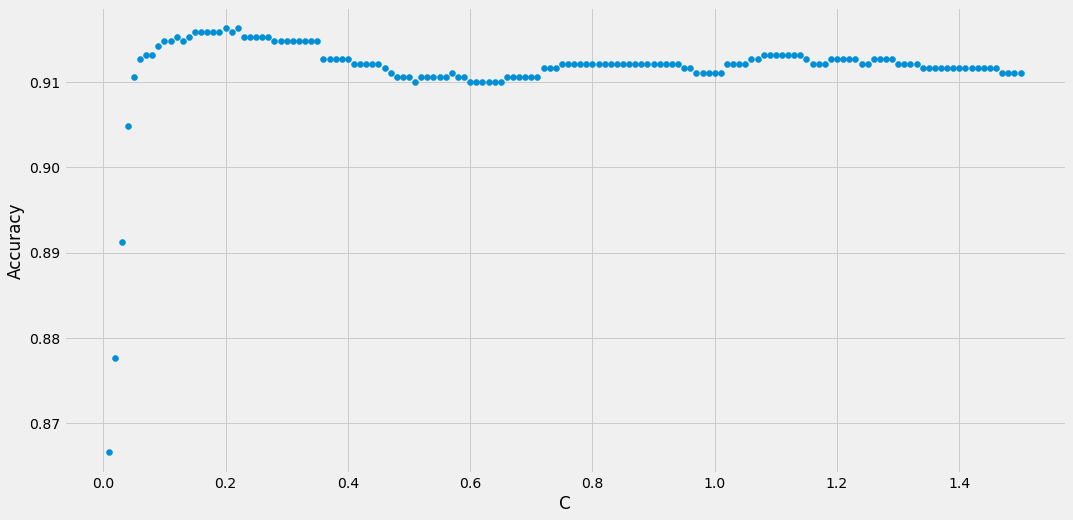

In [94]:
optCV_C_accuracy(0.01, 1.5, 0.01)

Optimized C in Logistic Regression with 10-fold Cross-Validation:
[[TN, FP], [FN, TP]] =
 [[1567   27]
 [ 110  208]]


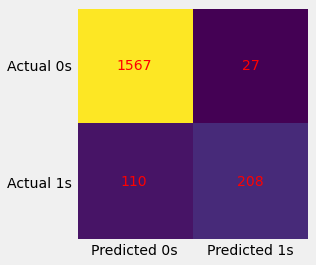

TNR = 0.9831 Specificity, proportion of the negative class 0 got correctly classified.
FNR = 0.3459 or Type II Error: Proportion of the positive class 1 got incorrectly classified.
roc_auc_score = 0.9539
Accuracy = 0.9283: (TN+TP)/(TN+TP+FN+FP): Percentage of total items classified correctly
FPR = 0.0169 Specificity, or Type I Error: proportion of the negative class 0 got incorrectly classified.
TPR = 0.6541: TP/(TP+FN): Recall, sensitivity, proportion of the positive class 1 got correctly classified.
Precision = 0.8851: TP/PP = TP/(TP+FP)
F1 score = 0.7523: harmonic mean of precision and recall.
MCC = 0.7226 Matthews correlation coefficient: accounts for all 4 confusion matrix categories.
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1594
           1       0.89      0.65      0.75       318

    accuracy                           0.93      1912
   macro avg       0.91      0.82      0.86      1912
weighted avg       0.93      

In [138]:
# Scores for the full data set
print('Optimized C in Logistic Regression with 10-fold Cross-Validation:')
C_opt = 2.76
lr_cv = LogisticRegression(solver='lbfgs', C=C_opt, random_state=0, max_iter=3000).fit(X_train, y_train) # Create and train model using training set
pred_Ccv = lr_cv.predict(X) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y, pred_Ccv)
metrics(X, y, lr_cv, tn,fp,fn,tp)
print(classification_report(y, pred_Ccv))

In [139]:
# CV average scores
#from sklearn.metrics import SCORERS
#sorted(SCORERS.keys()) # scoring options
roc_auc = np.mean(cross_val_score(lr_cv, X, y, scoring='roc_auc', cv=10)) # accuracies of cv cross-validations
accuracy = np.mean(cross_val_score(lr_cv, X, y, scoring='accuracy', cv=10))
recall = np.mean(cross_val_score(lr_cv, X, y, scoring='recall', cv=10))
precision = np.mean(cross_val_score(lr_cv, X, y, scoring='precision', cv=10))
f1 = np.mean(cross_val_score(lr_cv, X, y, scoring='f1', cv=10))

print("roc_auc\taccuracy\trecall\tprecision\tf1")
print("%.4f | %.4f | %.4f | %.4f | %.4f" % (roc_auc, accuracy, recall, precision, f1))

roc_auc	accuracy	recall	precision	f1
0.9169 | 0.9111 | 0.6194 | 0.8106 | 0.6931


### Quality metrics
F1 score is very sensitive to what is called a positive and a negative class. Since we want to correctly classify the positive class is_churn == 1, a higher TPR and a lower FNR is desirable. We use ROC-AUC score as a main quality metric.

| Transactions | Cut-off date | Mode | solver | C | ROC AUC | Accuracy | FPR | TPR | Precision | F1 | MCC |
|---:|:-------------|:-----------|:------|:------|:------|:------|:------|:------|:------|:------|:------|
| 1 | 2016-10-22 | No split | - | 1 | 0.9570 | 0.9247 | 0.0182 | 0.6384 | 0.875 | 0.7382 | 0.7072 |
| 1 | 2016-10-22 | 30% Test | - | 1 | 0.9212 | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test, opt. C | - | 1.55 | 0.9281 | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
|---|-------------|---------|------|--------|--------|--------|--------|--------|--------|
| 1 | 2016-10-22 | CV 10 | lbfgs | 2.76 | 0.9169* | 0.9111* | - | 0.6194* | 0.8106* | 0.6931* | - |
| 1 | 2016-10-22 | CV 10 | lbfgs | 2.76 | 0.9539 | 0.9283 | 0.0169 | 0.6541 | 0.8851 | 0.7523 | 0.7226 |
| 1 | 2016-10-22 | CV 10 | newton-cg | ? | ? | ? | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test | liblinear | 1 | ? | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test | sag | 1 | ? | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test | saga | 1 | ? | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
* average over 10 CV folds.

### ROC - AUC, Optimization of classification threshold
Area Under the Curve (AUC) of Receiver Characteristic Operator (ROC) helps us visualize how well our machine learning classifier is performing and choose the optimal classification threshold probability.

https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

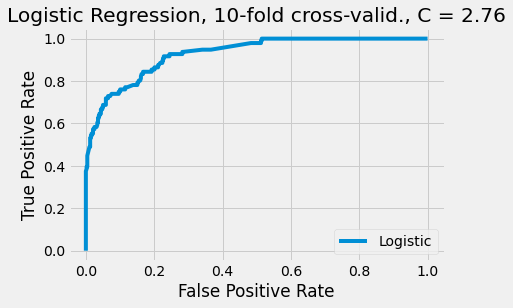

AUC: 0.928


In [144]:
prob_cv = lr_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, prob_cv, pos_label=1, drop_intermediate=False)
plt.plot(fpr, tpr, linestyle='-', label='Logistic')
plt.title(f'Logistic Regression, 10-fold cross-valid., C = {C_opt}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
pred_prob = lr_cv.predict_proba(X_test)
print('AUC: %.3f' % roc_auc_score(y_test, pred_prob[:,1]))

Manual ROC curve with controllable no. of threshold probabilities.

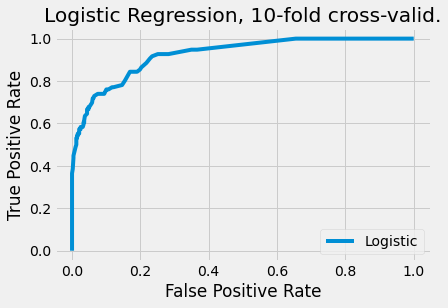

AUC: 0.928


In [145]:
pred_prob = lr_cv.predict_proba(X_test) # probability of y=0 (1st column) and y=1 (2nd column)
prob_step = 0.01
fpr = np.empty(int(1+1/prob_step))
tpr = np.empty(int(1+1/prob_step))
j = 0 # counter of points
thresholds = np.arange(0, 1+prob_step, prob_step)
for prob_thresh in thresholds:
    tn = 0; fn = 0; tp = 0; fp = 0;
    for i in range(pred_prob.shape[0]): # each test case
        if pred_prob[i,1] >= prob_thresh: # classify as 1
            if y_test[i] == 0: # actual 0
                fp = fp+1
            else: # actual 1
                tp = tp+1
        else: # classify as 0
            if y_test[i] == 0: # actual 0
                tn = tn+1
            else: # actual 1
                fn = fn+1
    fpr[j] = fp/(tn + fp) # specificity
    tpr[j] = tp/(tp + fn) # sensitivity
    j = j+1
#print("FPR =",fpr)
#print("TPR =",fpr)
# ROC curve
plt.plot(fpr, tpr, linestyle='-', label='Logistic')
plt.title('Logistic Regression, 10-fold cross-valid.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print('AUC: %.3f' % roc_auc_score(y_test, pred_prob[:,1]))

In [147]:
print("Performance for a given decision threshold")
#from sklearn.metrics import accuracy_score, recall_score, precision_score
THRESHOLD = 0.5
preds = np.where(pred_prob[:,1] > THRESHOLD, 1, 0)
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"], columns=['Score'])

Performance for a given decision threshold


,Score
accuracy,0.907666
recall,0.583333
precision,0.811594
roc_auc_score,0.778068


### Optimize decision threshold

In [149]:
# calculate the squared g-mean for each threshold
gmeans_sq = tpr * (1-fpr)
# locate the index of the largest g-mean
ix = np.argmax(gmeans_sq)
print('Best Threshold = %.4f, G-Mean_sq = %.4f' % (thresholds[ix], gmeans_sq[ix]))
print('FPR = %.4f, TPR = %.4f' % (fpr[ix], tpr[ix]))

Best Threshold = 0.0700, G-Mean_sq = 0.7019
FPR = 0.2343, TPR = 0.9167


In [150]:
#from sklearn.metrics import accuracy_score, recall_score, precision_score
preds = np.where(pred_prob[:,1] > thresholds[ix], 1, 0)
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"], columns=['Score'])

,Score
accuracy,0.790941
recall,0.916667
precision,0.440000
roc_auc_score,0.841179


### Optimize solver

In [ ]:
optCV_C_rocauc(0.1, 100, 0.1, solver='newton-cg')

In [ ]:
print('Optimize C using 10-fold cross-validation, lbfgs solver')
log_reg_lbfgs = LogisticRegression(solver='lbfgs')
accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
acc_opt = 0
for C in np.arange(0.1, 100.0, 0.1):
    C = round(C,1)
    log_reg_cv_lbfgs = LogisticRegression(solver='lbfgs', C=C, random_state=0, max_iter=3000)
    scores = cross_val_score(log_reg_cv_lbfgs, X_train, y_train, cv=10) # accuracies of cv cross-validations
    acc = scores.mean()
    accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
    if acc_opt < acc:
        acc_opt = acc
        C_opt = C
    #if C % 10 == 0: print("C =",C)
print('Optimal C =',C_opt)
print('Highest accuracy =',acc_opt)
plt.scatter(accuracy['C'],accuracy['Accuracy']);
plt.xlabel('C');
plt.ylabel('Accuracy');

In [ ]:
print('Optimize C using 10-fold cross-validation, lbfgs solver')
log_reg_lbfgs = LogisticRegression(solver='lbfgs')
accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
acc_opt = 0
for C in np.arange(0.01, 10.01, 0.01):
    #C = round(C,1)
    log_reg_cv_lbfgs = LogisticRegression(solver='lbfgs', C=C, random_state=0, max_iter=3000)
    scores = cross_val_score(log_reg_cv_lbfgs, X_train, y_train, cv=10) # accuracies of cv cross-validations
    acc = scores.mean()
    accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
    if acc_opt < acc:
        acc_opt = acc
        C_opt = C
    #if C % 10 == 0: print("C =",C)
print('Optimal C =',C_opt)
print('Highest accuracy =',acc_opt)
plt.scatter(accuracy['C'],accuracy['Accuracy']);
plt.xlabel('C');
plt.ylabel('Accuracy');

In [ ]:
C_opt=0.04
log_reg_cv_lbfgs = LogisticRegression(solver='lbfgs', C=C_opt, random_state=0, max_iter=3000)
log_reg_cv_lbfgs.fit(X_test, y_test)
scores = cross_val_score(log_reg_cv_lbfgs, X_train, y_train, cv=10) # accuracies of cv cross-validations
acc = scores.mean()
print("Accuracy =",acc)
prob_cv_lbfgs = log_reg_cv_lbfgs.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, prob_cv_lbfgs, pos_label=1, drop_intermediate=False)

In [ ]:
### Optimize decision threshold
# calculate the squared g-mean for each threshold
gmeans_sq = tpr*(1-fpr)
# locate the index of the largest g-mean
ix = np.argmax(gmeans_sq)
print('Best Threshold=%.4f, G-Mean_sq=%.4f' % (thresh[ix], gmeans_sq[ix]))
print('FPR=%.4f, TPR=%.4f' % (fpr[ix], tpr[ix]))

from sklearn.metrics import accuracy_score, recall_score, precision_score
THRESHOLD = thresh[ix]
preds = np.where(log_reg_cv.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])